In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

In [2]:
df = pd.read_csv('tg_users_groups_actions_202412022343.csv')
df

,id,chat_id,action,action_from,action_to,reply_on_id,reply_on_chat_id,message_id,message_chat_id,time,created_at
0,2191,-1001489613436,message,1309325426,NaN,NaN,NaN,24701,-1001489613436,2024-08-19 17:01:37.000 +0300,2024-11-25 19:35:49.489
1,2192,-1001489613436,message,1309325426,NaN,NaN,NaN,24700,-1001489613436,2024-08-19 17:01:30.000 +0300,2024-11-25 19:35:49.594
2,4,1,message,11,NaN,NaN,NaN,12,1,2023-10-25 15:30:00.000 +0300,2024-11-25 15:14:19.284
3,8,-1002462279841,message,374150300,NaN,NaN,NaN,26,-1002462279841,2024-11-18 21:32:07.000 +0300,2024-11-25 18:59:12.059
4,9,-1002462279841,message,374150300,NaN,NaN,NaN,25,-1002462279841,2024-11-18 21:17:46.000 +0300,2024-11-25 18:59:12.422
...,...,...,...,...,...,...,...,...,...,...,...
14769,17110,-1001263827769,message,7775240024,NaN,NaN,NaN,24409338,-1001263827769,2024-12-02 13:50:02.000 +0300,2024-12-02 20:27:54.905
14770,17111,-1001263827769,message,7504944020,NaN,NaN,NaN,24409337,-1001263827769,2024-12-02 13:50:00.000 +0300,2024-12-02 20:27:55.039
14771,17112,-1001263827769,message,7723360933,NaN,NaN,NaN,24409336,-1001263827769,2024-12-02 13:50:00.000 +0300,2024-12-02 20:27:55.481
14772,17113,-1001263827769,message,7146830509,NaN,NaN,NaN,24409334,-1001263827769,2024-12-02 13:49:40.000 +0300,2024-12-02 20:27:55.620


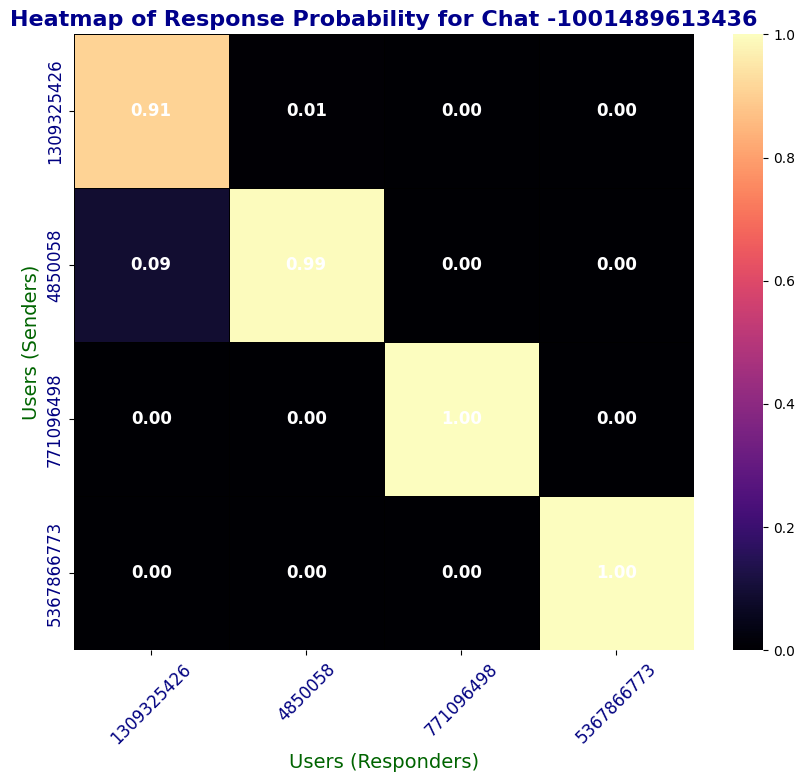

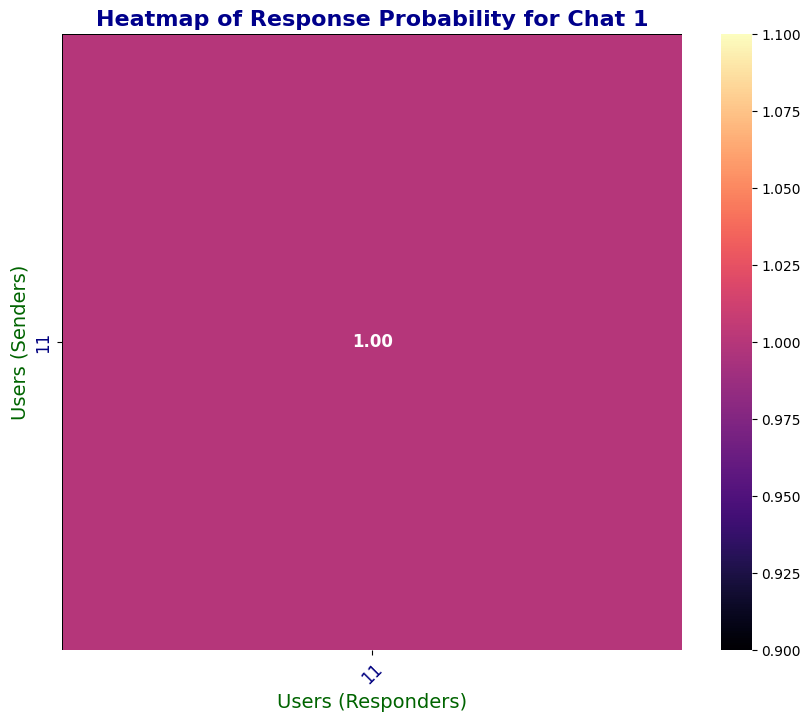

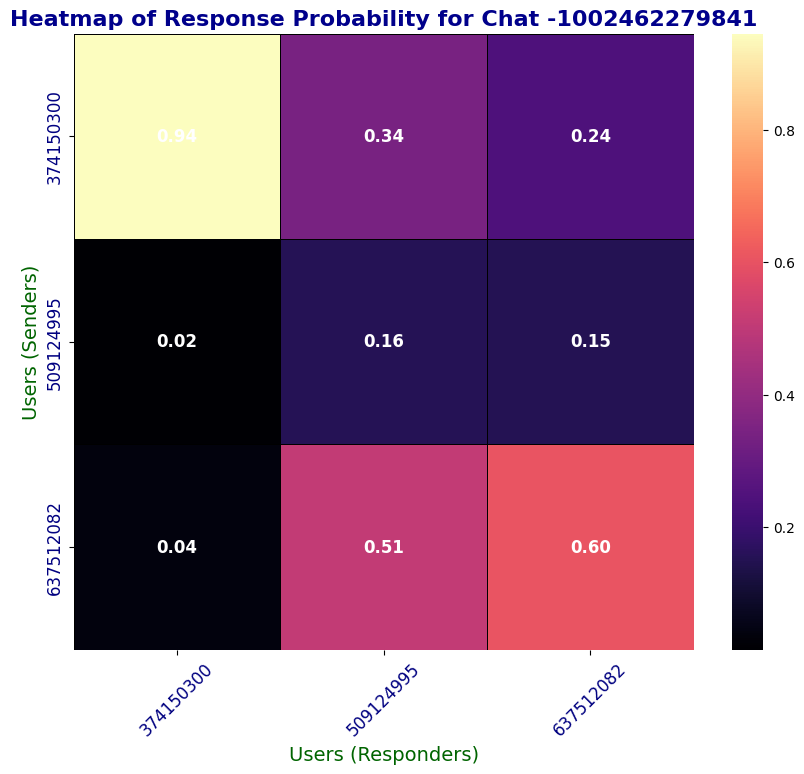

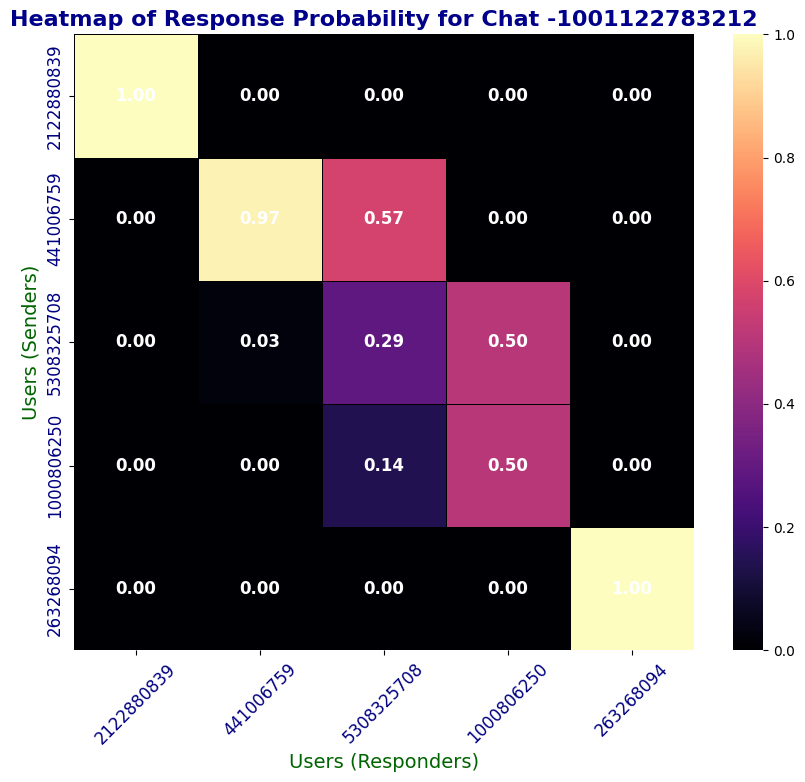

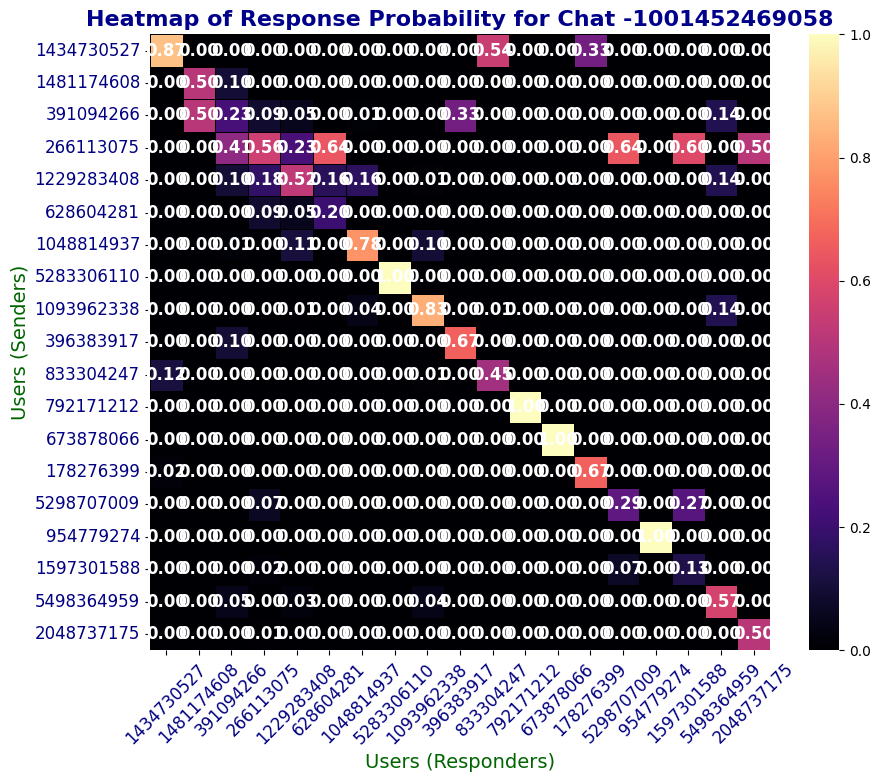

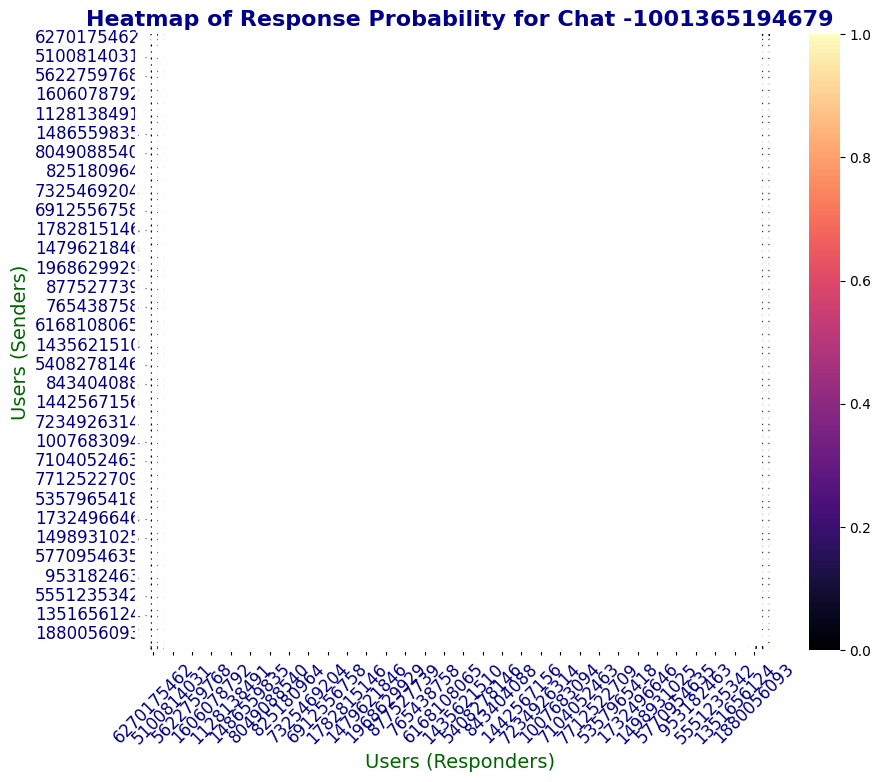

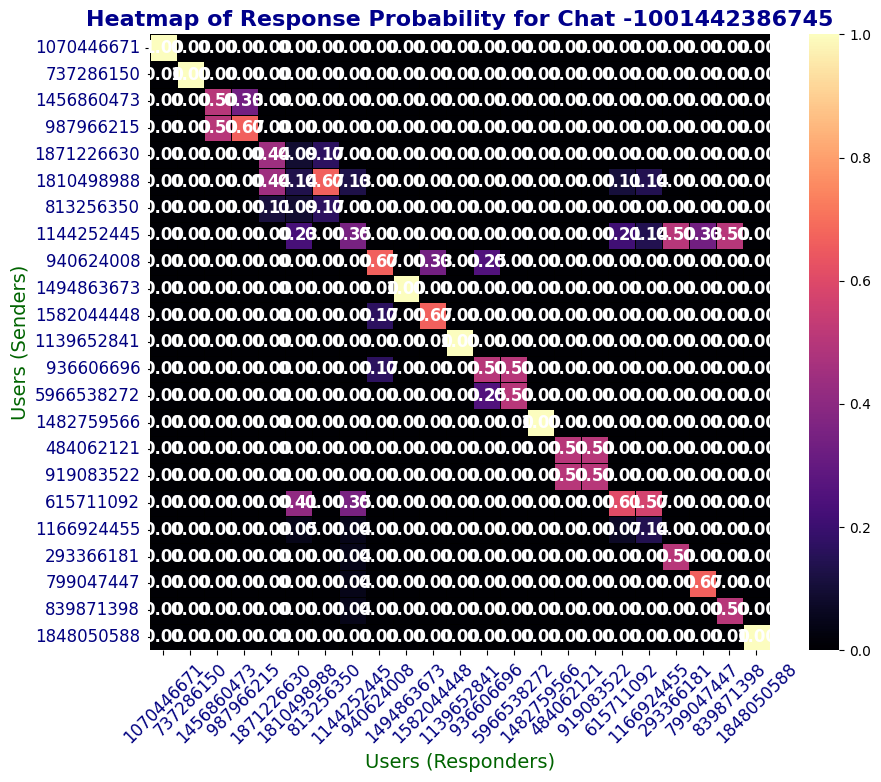

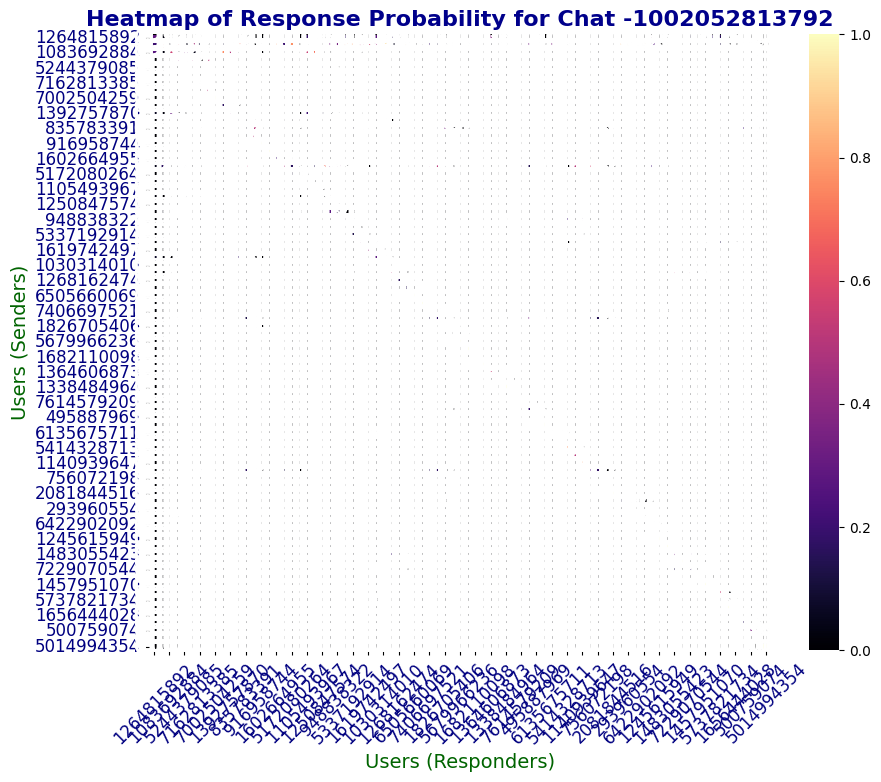

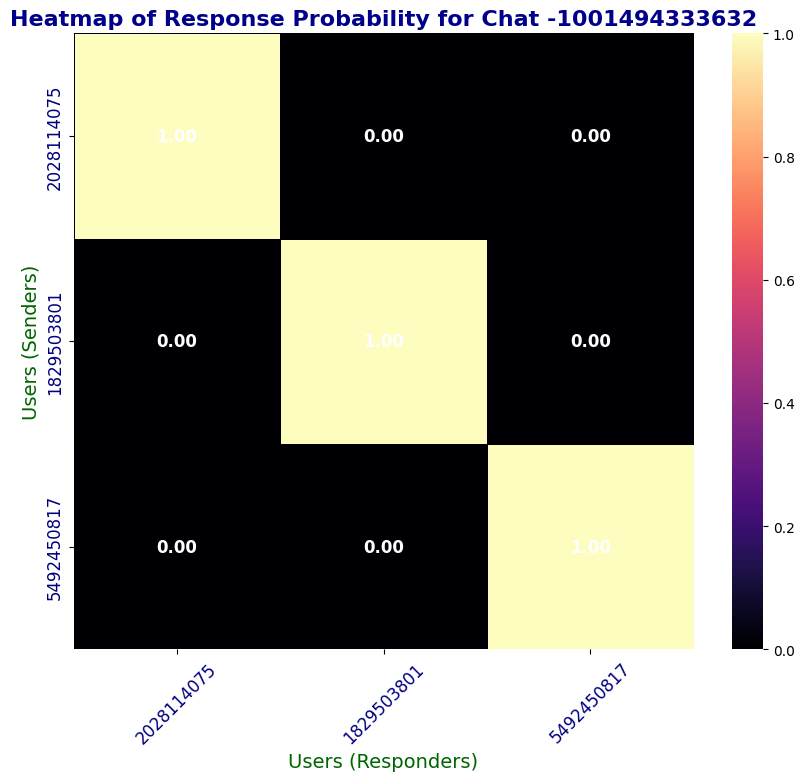

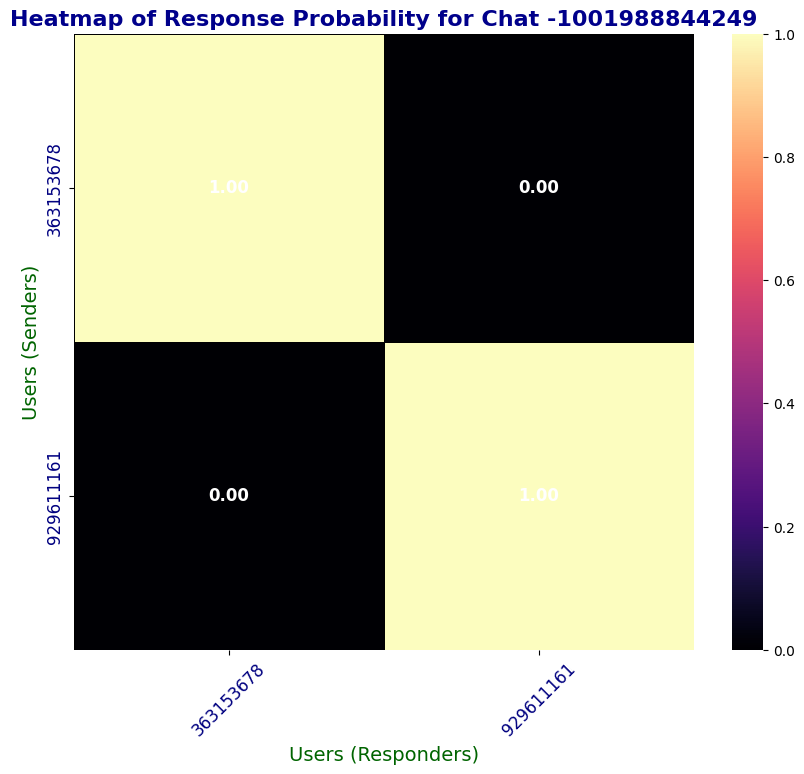

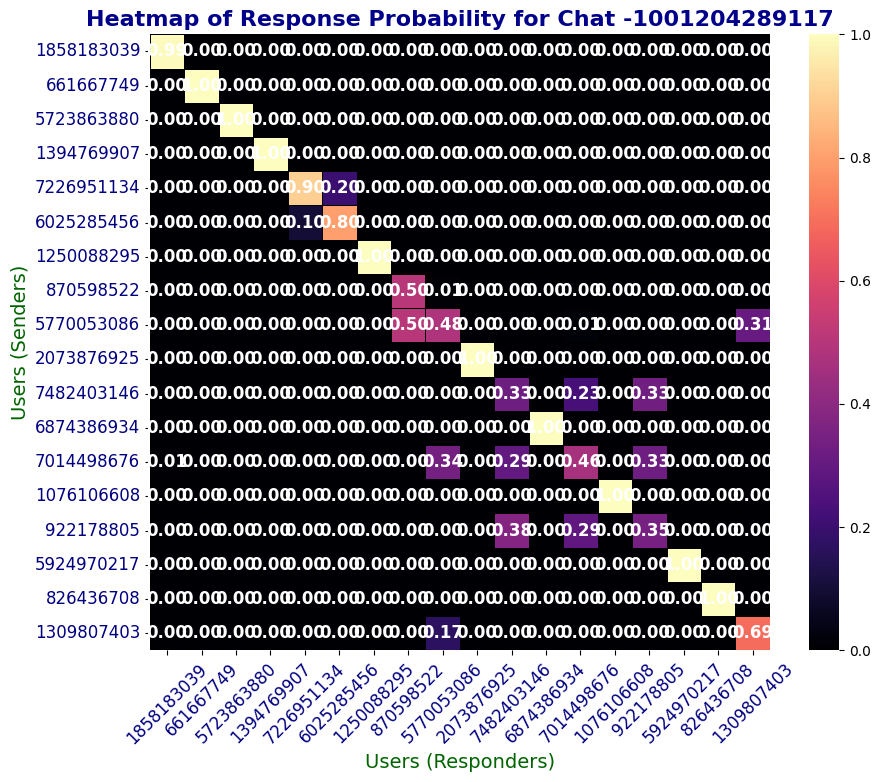

KeyboardInterrupt: 

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


df['time'] = pd.to_datetime(df['time'])

time_window = pd.Timedelta('5 minutes')

action_weights = {
    'forward': 1,
    'add': 2,
    'reply': 3,
    'tag': 4

}

df['weight'] = df['action'].map(action_weights).fillna(1)

for chat in df['chat_id'].unique():
    chat_messages = df[df['chat_id'] == chat]
    unique_users = df['action_from'].unique()
    probabilities_matrix = pd.DataFrame(0, index=unique_users, columns=unique_users)

    for user in unique_users:
        user_messages = chat_messages[chat_messages['action_from'] == user]
        for message_time in user_messages['time']:
            replies_within_window = chat_messages[
                (chat_messages['time'] > message_time - time_window) &
                (chat_messages['time'] <= message_time + time_window)]

            for responder in replies_within_window['action_from']:
                probabilities_matrix.loc[responder, user] += replies_within_window[replies_within_window['action_from'] == responder]['weight'].sum()

    probabilities_matrix = probabilities_matrix.div(probabilities_matrix.sum(axis=0), axis=1)
    
    probabilities_matrix = probabilities_matrix.loc[(probabilities_matrix.sum(axis=1) > 0), 
                                                    (probabilities_matrix.sum(axis=0) > 0)]

    if probabilities_matrix.empty:
        print(f'No interactions for chat {chat}. Skipping heatmap.')
        continue


    plt.figure(figsize=(10, 8))

    cmap = 'magma'

    sns.heatmap(probabilities_matrix, 
                annot=True, 
                cmap=cmap,
                fmt='.2f', 
                cbar=True, 
                annot_kws={'size': 12, 'weight': 'bold', 'color': 'white'},
                linewidths=.5,
                linecolor='black'
              )

    plt.title(f'Heatmap of Response Probability for Chat {chat}', fontsize=16, fontweight='bold', color='darkblue')

    plt.xlabel('Users (Responders)', fontsize=14, color='darkgreen')  
    plt.ylabel('Users (Senders)', fontsize=14, color='darkgreen')  

    plt.xticks(fontsize=12, rotation=45, color='navy')
    plt.yticks(fontsize=12, color='navy')

    plt.show()



